In [87]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [88]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [89]:
# load the data and perform data cleaning
df = pd.read_csv("data/spam.csv")
# remove any rows with null values
df.dropna(inplace=True)
# remove any duplicate rows
df.drop_duplicates(inplace=True)
# convert all text to lowercase
df['Message'] = df['Message'].str.lower()
# remove any leading or trailing whitespaces
df['Message'] = df['Message'].str.strip()

In [90]:
# preprocess the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Message'])
sequences = tokenizer.texts_to_sequences(df['Message'])
word_index = tokenizer.word_index
max_sequence_length = max([len(seq) for seq in sequences])
data = pad_sequences(sequences, maxlen=max_sequence_length)
print (data)

[[   0    0    0 ...   56 4005  137]
 [   0    0    0 ...  435    6 1766]
 [   0    0    0 ...  707  437 4006]
 ...
 [   0    0    0 ...  100  240 9003]
 [   0    0    0 ...  192   12   53]
 [   0    0    0 ...    2   63  284]]


In [91]:
# create labels
labels = np.where(df['Category']=='spam', 1, 0)

In [92]:
# split the data into training and validation sets
validation_split = 0.2
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(validation_split * data.shape[0])
x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

In [93]:
# build the model RNN LSTM
model = Sequential()
model.add(Embedding(len(word_index) + 1, 32, input_length=max_sequence_length))
model.add(SimpleRNN(32, return_sequences=True))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

# train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=128, validation_data=(x_val, y_val))

Train on 4126 samples, validate on 1031 samples
Epoch 1/10
4126/4126 [==============================] - 14s 3ms/step - loss: 0.3680 - acc: 0.8507 - val_loss: 0.2083 - val_acc: 0.9467
Epoch 2/10
4126/4126 [==============================] - 12s 3ms/step - loss: 0.1503 - acc: 0.9600 - val_loss: 0.0962 - val_acc: 0.9748
Epoch 3/10
4126/4126 [==============================] - 13s 3ms/step - loss: 0.0883 - acc: 0.9779 - val_loss: 0.0808 - val_acc: 0.9758
Epoch 4/10
4126/4126 [==============================] - 13s 3ms/step - loss: 0.0557 - acc: 0.9872 - val_loss: 0.0738 - val_acc: 0.9787
Epoch 5/10
4126/4126 [==============================] - 11s 3ms/step - loss: 0.0347 - acc: 0.9922 - val_loss: 0.9486 - val_acc: 0.4937
Epoch 6/10
4126/4126 [==============================] - 12s 3ms/step - loss: 0.0772 - acc: 0.9702 - val_loss: 0.0766 - val_acc: 0.9719
Epoch 7/10
4126/4126 [==============================] - 11s 3ms/step - loss: 0.0212 - acc: 0.9952 - val_loss: 0.0737 - val_acc: 0.9796
Epoch 8

In [95]:
from sklearn.model_selection import train_test_split
test_size = 0.2
x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=test_size, random_state=42)

In [96]:
# define a function to predict the category of a mail
def predict_category():
    # get the mail contents from the text box
    mail_contents = mail_text_box.get('1.0', tk.END)
    
    # preprocess the mail text
    mail_sequence = tokenizer.texts_to_sequences([mail_contents])
    mail_sequence_padded = pad_sequences(mail_sequence, maxlen=max_sequence_length)
    
    # predict the category of the mail
    score = model.predict(mail_sequence_padded)
    if score > 0.5:
        result_label.config(text='SPAM')
    else:
        result_label.config(text='NOT SPAM')

In [97]:
# define a function to generate a sample legitimate email
def generate_legitimate_email():
    # get a random index for a legitimate email
    index = np.random.choice(np.where(labels == 0)[0])
    
    # get the contents of the email
    mail_contents = df.loc[index, 'Message']
    
    # display the contents of the email in the text box
    mail_text_box.delete('1.0', tk.END)
    mail_text_box.insert(tk.END, mail_contents)

In [98]:
# define a function to generate a sample spam email
def generate_spam_email():
    # get a random index for a spam email
    index = np.random.choice(np.where(labels == 1)[0])
    
    # get the contents of the email
    mail_contents = df.loc[index, 'Message']
    
    # display the contents of the email in the text box
    mail_text_box.delete('1.0', tk.END)
    mail_text_box.insert(tk.END, mail_contents)

In [99]:
# define a function to reset the GUI
def reset_gui():
    mail_text_box.delete('1.0', tk.END)
    result_label.config(text='')

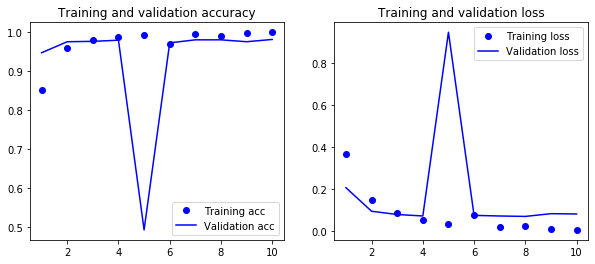

In [100]:
# plot the training and validation accuracy and loss
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# create the GUI
root = tk.Tk()
root.title('Spam Classifier')
root.geometry('800x600')

# create the mail text box
mail_text_box = tk.Text(root, font=('Helvetica', 12), height=10)
mail_text_box.pack(padx=15, pady=15, fill=tk.BOTH, expand=True)

# create the predict button
predict_button = tk.Button(root, text='Predict', command=predict_category)
predict_button.pack(pady=10)

# create the result label
result_label = tk.Label(root, text='', font=('Helvetica', 20))
result_label.pack(pady=10)

# create the generate buttons
generate_legitimate_button = tk.Button(root, text='Generate Legitimate Email/URL', command=generate_legitimate_email)
generate_legitimate_button.pack(pady=5)

generate_spam_button = tk.Button(root, text='Generate Spam Email/URL', command=generate_spam_email)
generate_spam_button.pack(pady=5)

# create the reset button
reset_button = tk.Button(root, text='Reset', command=reset_gui)
reset_button.pack(pady=10)

root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\richa\anaconda3\lib\site-packages\pandas\core\indexes\base.py", line 2646, in get_loc
    return self._engine.get_loc(key)
  File "pandas\_libs\index.pyx", line 111, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\index.pyx", line 138, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 997, in pandas._libs.hashtable.Int64HashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 1004, in pandas._libs.hashtable.Int64HashTable.get_item
KeyError: 1152

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\richa\anaconda3\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "<ipython-input-97-1e282a9c5b22>", line 7, in generate_legitimate_email
    mail_contents = df.loc[index, 'Message']
  File "C:\Users\richa\anaconda3\lib\site-packages